### PASCAL VOC 2007 데이터셋 다운로드

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCDetection

dataset = VOCDetection('./data', year='2007', image_set='trainval', download=True)

img, target = dataset.__getitem__(100)
img = np.array(img)

print(target)
print(img.shape)

# cv2.imshow('img', img)
# cv2.waitKey(0)

100%|██████████| 460032000/460032000 [00:42<00:00, 10787067.32it/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
{'annotation': {'folder': 'VOC2007', 'filename': '000203.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '320686966'}, 'owner': {'flickrid': 'yourFAVORITEmartian', 'name': 'Marvin'}, 'size': {'width': '500', 'height': '333', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'chair', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '0', 'bndbox': {'xmin': '52', 'ymin': '166', 'xmax': '167', 'ymax': '332'}}]}}
(333, 500, 3)


### xmltodict 패키지 설치

In [3]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### utils 구현

In [4]:
import os
import numpy as np
import xmltodict
import torch
import matplotlib.pyplot as plt

def check_dir(data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

def parse_car_csv(csv_dir):
    csv_path = os.path.join(csv_dir, 'car.csv')
    samples = np.loadtxt(csv_path, dtype=str)
    return samples


def parse_xml(xml_path):
    # print(xml_path)
    with open(xml_path, 'rb') as f:
        xml_dict = xmltodict.parse(f)
        # print(xml_dict)

        bndboxs = list()
        objects = xml_dict['annotation']['object']
        if isinstance(objects, list):
            for obj in objects:
                obj_name = obj['name']
                difficult = int(obj['difficult'])
                if 'car'.__eq__(obj_name) and difficult != 1:
                    bndbox = obj['bndbox']
                    bndboxs.append((int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])))
        elif isinstance(objects, dict):
            obj_name = objects['name']
            difficult = int(objects['difficult'])
            if 'car'.__eq__(obj_name) and difficult != 1:
                bndbox = objects['bndbox']
                bndboxs.append((int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])))
        else:
            pass

        return np.array(bndboxs)


def iou(pred_box, target_box):
    if len(target_box.shape) == 1:
        target_box = target_box[np.newaxis, :]

    xA = np.maximum(pred_box[0], target_box[:, 0])
    yA = np.maximum(pred_box[1], target_box[:, 1])
    xB = np.minimum(pred_box[2], target_box[:, 2])
    yB = np.minimum(pred_box[3], target_box[:, 3])

    intersection = np.maximum(0.0, xB - xA) * np.maximum(0.0, yB - yA)

    boxAArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    boxBArea = (target_box[:, 2] - target_box[:, 0]) * (target_box[:, 3] - target_box[:, 1])

    scores = intersection / (boxAArea + boxBArea - intersection)
    return scores


def compute_ious(rects, bndboxs):
    iou_list = list()
    for rect in rects:
        scores = iou(rect, bndboxs)
        iou_list.append(max(scores))
    return iou_list

def save_model(model, model_save_path):
    check_dir('./models')
    torch.save(model.state_dict(), model_save_path)

def plot_loss(loss_list):
    x = list(range(len(loss_list)))
    fg = plt.figure()

    plt.plot(x, loss_list)
    plt.title('loss')
    plt.savefig('./loss.png')

###  훈련용 car 데이터 분리 후 저장

In [5]:
import os
import sys
import shutil
import random
import numpy as np

suffix_xml = '.xml'
suffix_jpeg = '.jpg'

car_train_path = './data/VOCdevkit/VOC2007/ImageSets/Main/car_train.txt'
car_val_path = './data/VOCdevkit/VOC2007/ImageSets/Main/car_val.txt'

voc_annotation_dir = './data/VOCdevkit/VOC2007/Annotations/'
voc_jpeg_dir = './data/VOCdevkit/VOC2007/JPEGImages/'

car_root_dir = './data/voc_car/'


def parse_train_val(data_path):
    samples = []

    with open(data_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            res = line.strip().split(' ')
            if len(res) == 3 and int(res[2]) == 1:
                samples.append(res[0])

    return np.array(samples)


def sample_train_val(samples):
    for name in ['train', 'val']:
        dataset = samples[name]
        length = len(dataset)

        random_samples = random.sample(range(length), int(length / 10))
        # print(random_samples)
        new_dataset = dataset[random_samples]
        samples[name] = new_dataset

    return samples

def save_car(car_samples, data_root_dir, data_annotation_dir, data_jpeg_dir):
    for sample_name in car_samples:
        src_annotation_path = os.path.join(voc_annotation_dir, sample_name + suffix_xml)
        dst_annotation_path = os.path.join(data_annotation_dir, sample_name + suffix_xml)
        shutil.copyfile(src_annotation_path, dst_annotation_path)

        src_jpeg_path = os.path.join(voc_jpeg_dir, sample_name + suffix_jpeg)
        dst_jpeg_path = os.path.join(data_jpeg_dir, sample_name + suffix_jpeg)
        shutil.copyfile(src_jpeg_path, dst_jpeg_path)

    csv_path = os.path.join(data_root_dir, 'car.csv')
    np.savetxt(csv_path, np.array(car_samples), fmt='%s')

In [6]:
samples = {'train': parse_train_val(car_train_path), 'val': parse_train_val(car_val_path)}
print(samples)
# samples = sample_train_val(samples)
# print(samples)

check_dir(car_root_dir)
for name in ['train', 'val']:
    data_root_dir = os.path.join(car_root_dir, name)
    data_annotation_dir = os.path.join(data_root_dir, 'Annotations')
    data_jpeg_dir = os.path.join(data_root_dir, 'JPEGImages')

    check_dir(data_root_dir)
    check_dir(data_annotation_dir)
    check_dir(data_jpeg_dir)
    save_car(samples[name], data_root_dir, data_annotation_dir, data_jpeg_dir)

print('done')

{'train': array(['000012', '000026', '000047', '000083', '000091', '000134',
       '000153', '000159', '000161', '000220', '000262', '000263',
       '000288', '000296', '000311', '000317', '000320', '000334',
       '000355', '000367', '000387', '000404', '000406', '000431',
       '000469', '000474', '000522', '000541', '000554', '000590',
       '000605', '000620', '000672', '000688', '000700', '000818',
       '000823', '000829', '000860', '000871', '000888', '000906',
       '000977', '001057', '001060', '001112', '001119', '001237',
       '001258', '001268', '001294', '001334', '001364', '001384',
       '001385', '001409', '001414', '001455', '001488', '001492',
       '001494', '001532', '001559', '001576', '001604', '001622',
       '001662', '001676', '001699', '001780', '001821', '001845',
       '001881', '001902', '001937', '001954', '001980', '002056',
       '002116', '002134', '002153', '002170', '002178', '002180',
       '002182', '002197', '002241', '002247', '0022

### Selective Search 관련 함수 구현

In [7]:
import sys
import cv2

def get_selective_search():
    gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    return gs


def config(gs, img, strategy='q'):
    gs.setBaseImage(img)

    if (strategy == 's'):
        gs.switchToSingleStrategy()
    elif (strategy == 'f'):
        gs.switchToSelectiveSearchFast()
    elif (strategy == 'q'):
        gs.switchToSelectiveSearchQuality()
    else:
        print(__doc__)
        sys.exit(1)


def get_rects(gs):
    rects = gs.process()
    rects[:, 2] += rects[:, 0]
    rects[:, 3] += rects[:, 1]

    return rects

In [9]:
gs = get_selective_search()

img = cv2.imread('./data/lena.png', cv2.IMREAD_COLOR)
config(gs, img, strategy='q')

rects = get_rects(gs)
print(rects.shape)

(6242, 4)


### Alexnet 미세 조정용 데이터셋 분리 및 저장

In [10]:
import os
import sys

import time
import shutil
import numpy as np
import cv2

# import selectivesearch

# train
# positive num: 66517
# negatie num: 464340
# val
# positive num: 64712
# negative num: 415134


def parse_annotation_jpeg(annotation_path, jpeg_path, gs):

    img = cv2.imread(jpeg_path)

    config(gs, img, strategy='q')

    rects = get_rects(gs)

    bndboxs = parse_xml(annotation_path)


    maximum_bndbox_size = 0
    for bndbox in bndboxs:
        xmin, ymin, xmax, ymax = bndbox
        bndbox_size = (ymax - ymin) * (xmax - xmin)
        if bndbox_size > maximum_bndbox_size:
            maximum_bndbox_size = bndbox_size


    iou_list = compute_ious(rects, bndboxs)

    positive_list = list()
    negative_list = list()
    for i in range(len(iou_list)):
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (ymax - ymin) * (xmax - xmin)

        iou_score = iou_list[i]
        if iou_list[i] >= 0.5:
            positive_list.append(rects[i])
        if 0 < iou_list[i] < 0.5 and rect_size > maximum_bndbox_size / 5.0:
            negative_list.append(rects[i])
        else:
            pass

    return positive_list, negative_list

In [11]:
car_root_dir = './data/voc_car/'
finetune_root_dir = './data/finetune_car/'
check_dir(finetune_root_dir)

gs = get_selective_search()
for name in ['train', 'val']:
    src_root_dir = os.path.join(car_root_dir, name)
    src_annotation_dir = os.path.join(src_root_dir, 'Annotations')
    src_jpeg_dir = os.path.join(src_root_dir, 'JPEGImages')

    dst_root_dir = os.path.join(finetune_root_dir, name)
    dst_annotation_dir = os.path.join(dst_root_dir, 'Annotations')
    dst_jpeg_dir = os.path.join(dst_root_dir, 'JPEGImages')
    check_dir(dst_root_dir)
    check_dir(dst_annotation_dir)
    check_dir(dst_jpeg_dir)

    total_num_positive = 0
    total_num_negative = 0

    samples = parse_car_csv(src_root_dir)

    src_csv_path = os.path.join(src_root_dir, 'car.csv')
    dst_csv_path = os.path.join(dst_root_dir, 'car.csv')
    shutil.copyfile(src_csv_path, dst_csv_path)
    for sample_name in samples:
        since = time.time()

        src_annotation_path = os.path.join(src_annotation_dir, sample_name + '.xml')
        src_jpeg_path = os.path.join(src_jpeg_dir, sample_name + '.jpg')

        positive_list, negative_list = parse_annotation_jpeg(src_annotation_path, src_jpeg_path, gs)
        total_num_positive += len(positive_list)
        total_num_negative += len(negative_list)

        dst_annotation_positive_path = os.path.join(dst_annotation_dir, sample_name + '_1' + '.csv')
        dst_annotation_negative_path = os.path.join(dst_annotation_dir, sample_name + '_0' + '.csv')
        dst_jpeg_path = os.path.join(dst_jpeg_dir, sample_name + '.jpg')

        shutil.copyfile(src_jpeg_path, dst_jpeg_path)

        np.savetxt(dst_annotation_positive_path, np.array(positive_list), fmt='%d', delimiter=' ')
        np.savetxt(dst_annotation_negative_path, np.array(negative_list), fmt='%d', delimiter=' ')

        time_elapsed = time.time() - since
        print('parse {}.png in {:.0f}m {:.0f}s'.format(sample_name, time_elapsed // 60, time_elapsed % 60))
    print('%s positive num: %d' % (name, total_num_positive))
    print('%s negative num: %d' % (name, total_num_negative))
print('done')

parse 000012.png in 0m 4s
parse 000026.png in 0m 4s
parse 000047.png in 0m 5s
parse 000083.png in 0m 5s
parse 000091.png in 0m 6s
parse 000134.png in 0m 5s
parse 000153.png in 0m 5s
parse 000159.png in 0m 5s
parse 000161.png in 0m 5s
parse 000220.png in 0m 5s
parse 000262.png in 0m 2s
parse 000263.png in 0m 5s
parse 000288.png in 0m 5s
parse 000296.png in 0m 4s
parse 000311.png in 0m 5s
parse 000317.png in 0m 6s
parse 000320.png in 0m 5s
parse 000334.png in 0m 4s
parse 000355.png in 0m 4s
parse 000367.png in 0m 6s
parse 000387.png in 0m 5s
parse 000404.png in 0m 4s
parse 000406.png in 0m 6s
parse 000431.png in 0m 4s
parse 000469.png in 0m 5s
parse 000474.png in 0m 5s
parse 000522.png in 0m 5s
parse 000541.png in 0m 5s
parse 000554.png in 0m 5s
parse 000590.png in 0m 5s
parse 000605.png in 0m 5s
parse 000620.png in 0m 5s
parse 000672.png in 0m 5s
parse 000688.png in 0m 5s
parse 000700.png in 0m 5s
parse 000818.png in 0m 4s
parse 000823.png in 0m 5s
parse 000829.png in 0m 5s
parse 000860

### 미세 조정용 데이터셋 로드 함수

In [12]:
import numpy  as np
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class CustomFinetuneDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        samples = parse_car_csv(root_dir)

        jpeg_images = [cv2.imread(os.path.join(root_dir, 'JPEGImages', sample_name + ".jpg"))
                       for sample_name in samples]

        positive_annotations = [os.path.join(root_dir, 'Annotations', sample_name + '_1.csv')
                                for sample_name in samples]
        negative_annotations = [os.path.join(root_dir, 'Annotations', sample_name + '_0.csv')
                                for sample_name in samples]

        positive_sizes = list()
        negative_sizes = list()

        positive_rects = list()
        negative_rects = list()

        for annotation_path in positive_annotations:
            rects = np.loadtxt(annotation_path, dtype=np.int32, delimiter=' ')

            if len(rects.shape) == 1:
                if rects.shape[0] == 4:
                    positive_rects.append(rects)
                    positive_sizes.append(1)
                else:
                    positive_sizes.append(0)
            else:
                positive_rects.extend(rects)
                positive_sizes.append(len(rects))
        for annotation_path in negative_annotations:
            rects = np.loadtxt(annotation_path, dtype=np.int32, delimiter=' ')
            if len(rects.shape) == 1:
                if rects.shape[0] == 4:
                    negative_rects.append(rects)
                    negative_sizes.append(1)
                else:
                    positive_sizes.append(0)
            else:
                negative_rects.extend(rects)
                negative_sizes.append(len(rects))

        self.transform = transform
        self.jpeg_images = jpeg_images
        self.positive_sizes = positive_sizes
        self.negative_sizes = negative_sizes
        self.positive_rects = positive_rects
        self.negative_rects = negative_rects
        self.total_positive_num = int(np.sum(positive_sizes))
        self.total_negative_num = int(np.sum(negative_sizes))

    def __getitem__(self, index: int):
        image_id = len(self.jpeg_images) - 1
        if index < self.total_positive_num:
            target = 1
            xmin, ymin, xmax, ymax = self.positive_rects[index]
            for i in range(len(self.positive_sizes) - 1):
                if np.sum(self.positive_sizes[:i]) <= index < np.sum(self.positive_sizes[:(i + 1)]):
                    image_id = i
                    break
            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
        else:
            target = 0
            idx = index - self.total_positive_num
            xmin, ymin, xmax, ymax = self.negative_rects[idx]
            for i in range(len(self.negative_sizes) - 1):
                if np.sum(self.negative_sizes[:i]) <= idx < np.sum(self.negative_sizes[:(i + 1)]):
                    image_id = i
                    break
            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]

        # print('index: %d image_id: %d target: %d image.shape: %s [xmin, ymin, xmax, ymax]: [%d, %d, %d, %d]' %
        #       (index, image_id, target, str(image.shape), xmin, ymin, xmax, ymax))
        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self) -> int:
        return self.total_positive_num + self.total_negative_num

    def get_positive_num(self) -> int:
        return self.total_positive_num

    def get_negative_num(self) -> int:
        return self.total_negative_num

positive num: 66165
negative num: 454789
total num: 520954
target: 1


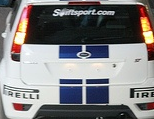

In [13]:
from google.colab.patches import cv2_imshow
idx = 0
root_dir = './data/finetune_car/train'
train_data_set = CustomFinetuneDataset(root_dir)

print('positive num: %d' % train_data_set.get_positive_num())
print('negative num: %d' % train_data_set.get_negative_num())
print('total num: %d' % train_data_set.__len__())

image, target = train_data_set.__getitem__(idx)
print('target: %d' % target)

cv2_imshow(image)
# image = Image.fromarray(image)
# print(image)
# print(type(image))

### 미니 배치 샘플러 처리 코드 구현

In [14]:
import numpy  as np
import random
from torch.utils.data import Sampler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class CustomBatchSampler(Sampler):

    def __init__(self, num_positive, num_negative, batch_positive, batch_negative) -> None:
        self.num_positive = num_positive
        self.num_negative = num_negative
        self.batch_positive = batch_positive
        self.batch_negative = batch_negative

        length = num_positive + num_negative
        self.idx_list = list(range(length))

        self.batch = batch_negative + batch_positive
        self.num_iter = length // self.batch

    def __iter__(self):
        sampler_list = list()
        for i in range(self.num_iter):
            tmp = np.concatenate(
                (random.sample(self.idx_list[:self.num_positive], self.batch_positive),
                 random.sample(self.idx_list[self.num_positive:], self.batch_negative))
            )
            random.shuffle(tmp)
            sampler_list.extend(tmp)
        return iter(sampler_list)

    def __len__(self) -> int:
        return self.num_iter * self.batch

    def get_num_batch(self) -> int:
        return self.num_iter

### AlexNet 미세 조정 훈련 및 모델 저장

In [15]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

def load_data(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_loaders = {}
    data_sizes = {}
    for name in ['train', 'val']:
        data_dir = os.path.join(data_root_dir, name)
        data_set = CustomFinetuneDataset(data_dir, transform=transform)
        data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 32, 96)
        data_loader = DataLoader(data_set, batch_size=128, sampler=data_sampler, num_workers=8, drop_last=True)

        data_loaders[name] = data_loader
        data_sizes[name] = data_sampler.__len__()

    return data_loaders, data_sizes


def train_model(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i=0
            for inputs, labels in data_loaders[phase]:
                i += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                print(i, running_loss)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

data_loaders, data_sizes = load_data('./data/finetune_car')

model = models.alexnet(pretrained=True)
# print(model)
num_features = model.classifier[6].in_features
# print(num_features)
model.classifier[6] = nn.Linear(num_features, 2)
# print(model)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# best_model = train_model(data_loaders, model, criterion, optimizer, lr_scheduler, device=device, num_epochs=20)
check_dir('./models')
# torch.save(best_model.state_dict(), 'models/alexnet_car.pth')

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 71.3MB/s]


### linear SVM용 데이터셋 분리 및 저장

In [21]:
import random
import numpy as np
import shutil
import time
import cv2
import os
import xmltodict

# train
# positive num: 625
# negative num: 366028
# val
# positive num: 625
# negative num: 321474

def parse_annotation_jpeg(annotation_path, jpeg_path, gs):
    img = cv2.imread(jpeg_path)

    config(gs, img, strategy='q')

    rects = get_rects(gs)

    bndboxs = parse_xml(annotation_path)


    maximum_bndbox_size = 0
    for bndbox in bndboxs:
        xmin, ymin, xmax, ymax = bndbox
        bndbox_size = (ymax - ymin) * (xmax - xmin)
        if bndbox_size > maximum_bndbox_size:
            maximum_bndbox_size = bndbox_size


    iou_list = compute_ious(rects, bndboxs)

    positive_list = list()
    negative_list = list()
    for i in range(len(iou_list)):
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (ymax - ymin) * (xmax - xmin)

        iou_score = iou_list[i]
        if 0 < iou_score <= 0.3 and rect_size > maximum_bndbox_size / 5.0:
            negative_list.append(rects[i])
        else:
            pass

    return bndboxs, negative_list

In [22]:
car_root_dir = './data/voc_car/'
classifier_root_dir = './data/classifier_car/'
check_dir(classifier_root_dir)

gs = get_selective_search()
for name in ['train', 'val']:
    src_root_dir = os.path.join(car_root_dir, name)
    src_annotation_dir = os.path.join(src_root_dir, 'Annotations')
    src_jpeg_dir = os.path.join(src_root_dir, 'JPEGImages')

    dst_root_dir = os.path.join(classifier_root_dir, name)
    dst_annotation_dir = os.path.join(dst_root_dir, 'Annotations')
    dst_jpeg_dir = os.path.join(dst_root_dir, 'JPEGImages')
    check_dir(dst_root_dir)
    check_dir(dst_annotation_dir)
    check_dir(dst_jpeg_dir)

    total_num_positive = 0
    total_num_negative = 0

    samples = parse_car_csv(src_root_dir)
    
    src_csv_path = os.path.join(src_root_dir, 'car.csv')
    dst_csv_path = os.path.join(dst_root_dir, 'car.csv')
    shutil.copyfile(src_csv_path, dst_csv_path)
    for sample_name in samples:
        since = time.time()

        src_annotation_path = os.path.join(src_annotation_dir, sample_name + '.xml')
        src_jpeg_path = os.path.join(src_jpeg_dir, sample_name + '.jpg')
        
        positive_list, negative_list = parse_annotation_jpeg(src_annotation_path, src_jpeg_path, gs)
        total_num_positive += len(positive_list)
        total_num_negative += len(negative_list)

        dst_annotation_positive_path = os.path.join(dst_annotation_dir, sample_name + '_1' + '.csv')
        dst_annotation_negative_path = os.path.join(dst_annotation_dir, sample_name + '_0' + '.csv')
        dst_jpeg_path = os.path.join(dst_jpeg_dir, sample_name + '.jpg')
        
        shutil.copyfile(src_jpeg_path, dst_jpeg_path)
        
        np.savetxt(dst_annotation_positive_path, np.array(positive_list), fmt='%d', delimiter=' ')
        np.savetxt(dst_annotation_negative_path, np.array(negative_list), fmt='%d', delimiter=' ')

        time_elapsed = time.time() - since
        print('parse {}.png in {:.0f}m {:.0f}s'.format(sample_name, time_elapsed // 60, time_elapsed % 60))
    print('%s positive num: %d' % (name, total_num_positive))
    print('%s negative num: %d' % (name, total_num_negative))
print('done')

parse 000012.png in 0m 4s
parse 000026.png in 0m 4s
parse 000047.png in 0m 5s
parse 000083.png in 0m 5s
parse 000091.png in 0m 6s
parse 000134.png in 0m 5s
parse 000153.png in 0m 5s
parse 000159.png in 0m 5s
parse 000161.png in 0m 5s
parse 000220.png in 0m 5s
parse 000262.png in 0m 2s
parse 000263.png in 0m 5s
parse 000288.png in 0m 5s
parse 000296.png in 0m 4s
parse 000311.png in 0m 5s
parse 000317.png in 0m 6s
parse 000320.png in 0m 5s
parse 000334.png in 0m 4s
parse 000355.png in 0m 4s
parse 000367.png in 0m 6s
parse 000387.png in 0m 5s
parse 000404.png in 0m 4s
parse 000406.png in 0m 6s
parse 000431.png in 0m 4s
parse 000469.png in 0m 5s
parse 000474.png in 0m 5s
parse 000522.png in 0m 5s
parse 000541.png in 0m 5s
parse 000554.png in 0m 5s
parse 000590.png in 0m 5s
parse 000605.png in 0m 5s
parse 000620.png in 0m 5s
parse 000672.png in 0m 5s
parse 000688.png in 0m 5s
parse 000700.png in 0m 5s
parse 000818.png in 0m 4s
parse 000823.png in 0m 5s
parse 000829.png in 0m 5s
parse 000860

### linear SVM 데이터셋 로드 함수 구현

In [25]:
import torch.nn as nn
from torch.utils.data import Dataset

class CustomHardNegativeMiningDataset(Dataset):

    def __init__(self, negative_list, jpeg_images, transform=None):
        self.negative_list = negative_list
        self.jpeg_images = jpeg_images
        self.transform = transform

    def __getitem__(self, index: int):
        target = 0

        negative_dict = self.negative_list[index]
        xmin, ymin, xmax, ymax = negative_dict['rect']
        image_id = negative_dict['image_id']

        image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
        if self.transform:
            image = self.transform(image)

        return image, target, negative_dict

    def __len__(self) -> int:
        return len(self.negative_list)

In [26]:
import numpy  as np
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class CustomClassifierDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        samples = parse_car_csv(root_dir)

        jpeg_images = list()
        positive_list = list()
        negative_list = list()
        for idx in range(len(samples)):
            sample_name = samples[idx]
            jpeg_images.append(cv2.imread(os.path.join(root_dir, 'JPEGImages', sample_name + ".jpg")))

            positive_annotation_path = os.path.join(root_dir, 'Annotations', sample_name + '_1.csv')
            positive_annotations = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')

            if len(positive_annotations.shape) == 1:
                if positive_annotations.shape[0] == 4:
                    positive_dict = dict()

                    positive_dict['rect'] = positive_annotations
                    positive_dict['image_id'] = idx
                    # positive_dict['image_name'] = sample_name

                    positive_list.append(positive_dict)
            else:
                for positive_annotation in positive_annotations:
                    positive_dict = dict()

                    positive_dict['rect'] = positive_annotation
                    positive_dict['image_id'] = idx
                    # positive_dict['image_name'] = sample_name

                    positive_list.append(positive_dict)

            negative_annotation_path = os.path.join(root_dir, 'Annotations', sample_name + '_0.csv')
            negative_annotations = np.loadtxt(negative_annotation_path, dtype=np.int, delimiter=' ')

            if len(negative_annotations.shape) == 1:
                if negative_annotations.shape[0] == 4:
                    negative_dict = dict()

                    negative_dict['rect'] = negative_annotations
                    negative_dict['image_id'] = idx
                    # negative_dict['image_name'] = sample_name

                    negative_list.append(negative_dict)
            else:
                for negative_annotation in negative_annotations:
                    negative_dict = dict()

                    negative_dict['rect'] = negative_annotation
                    negative_dict['image_id'] = idx
                    # negative_dict['image_name'] = sample_name

                    negative_list.append(negative_dict)

        self.transform = transform
        self.jpeg_images = jpeg_images
        self.positive_list = positive_list
        self.negative_list = negative_list

    def __getitem__(self, index: int):
        if index < len(self.positive_list):
            target = 1
            positive_dict = self.positive_list[index]

            xmin, ymin, xmax, ymax = positive_dict['rect']
            image_id = positive_dict['image_id']

            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
            cache_dict = positive_dict
        else:
            target = 0
            idx = index - len(self.positive_list)
            negative_dict = self.negative_list[idx]

            xmin, ymin, xmax, ymax = negative_dict['rect']
            image_id = negative_dict['image_id']

            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
            cache_dict = negative_dict

        # print('index: %d image_id: %d target: %d image.shape: %s [xmin, ymin, xmax, ymax]: [%d, %d, %d, %d]' %
        #       (index, image_id, target, str(image.shape), xmin, ymin, xmax, ymax))
        if self.transform:
            image = self.transform(image)

        return image, target, cache_dict

    def __len__(self) -> int:
        return len(self.positive_list) + len(self.negative_list)

    def get_transform(self):
        return self.transform

    def get_jpeg_images(self) -> list:
        return self.jpeg_images

    def get_positive_num(self) -> int:
        return len(self.positive_list)

    def get_negative_num(self) -> int:
        return len(self.negative_list)

    def get_positives(self) -> list:
        return self.positive_list

    def get_negatives(self) -> list:
        return self.negative_list

    def set_negative_list(self, negative_list):
        self.negative_list = negative_list

### linear SVM  모델 학습 및 모델 저장

In [28]:
import time
import copy
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import alexnet

batch_positive = 32
batch_negative = 96
batch_total = 128


def load_data(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_loaders = {}
    data_sizes = {}
    remain_negative_list = list()
    for name in ['train', 'val']:
        data_dir = os.path.join(data_root_dir, name)

        data_set = CustomClassifierDataset(data_dir, transform=transform)
        if name == 'train':

            positive_list = data_set.get_positives()
            negative_list = data_set.get_negatives()

            init_negative_idxs = random.sample(range(len(negative_list)), len(positive_list))
            init_negative_list = [negative_list[idx] for idx in range(len(negative_list)) if idx in init_negative_idxs]
            remain_negative_list = [negative_list[idx] for idx in range(len(negative_list))
                                    if idx not in init_negative_idxs]

            data_set.set_negative_list(init_negative_list)
            data_loaders['remain'] = remain_negative_list

        sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(),
                                     batch_positive, batch_negative)

        data_loader = DataLoader(data_set, batch_size=batch_total, sampler=sampler, num_workers=8, drop_last=True)
        data_loaders[name] = data_loader
        data_sizes[name] = len(sampler)
    return data_loaders, data_sizes


def hinge_loss(outputs, labels):
    num_labels = len(labels)
    corrects = outputs[range(num_labels), labels].unsqueeze(0).T

    margin = 1.0
    margins = outputs - corrects + margin
    loss = torch.sum(torch.max(margins, 1)[0]) / len(labels)

    # reg = 1e-3
    # loss += reg * torch.sum(weight ** 2)

    return loss


def add_hard_negatives(hard_negative_list, negative_list, add_negative_list):
    for item in hard_negative_list:
        if len(add_negative_list) == 0:
            negative_list.append(item)
            add_negative_list.append(list(item['rect']))
        if list(item['rect']) not in add_negative_list:
            negative_list.append(item)
            add_negative_list.append(list(item['rect']))


def get_hard_negatives(preds, cache_dicts):
    fp_mask = preds == 1
    tn_mask = preds == 0

    fp_rects = cache_dicts['rect'][fp_mask].numpy()
    fp_image_ids = cache_dicts['image_id'][fp_mask].numpy()

    tn_rects = cache_dicts['rect'][tn_mask].numpy()
    tn_image_ids = cache_dicts['image_id'][tn_mask].numpy()

    hard_negative_list = [{'rect': fp_rects[idx], 'image_id': fp_image_ids[idx]} for idx in range(len(fp_rects))]
    easy_negatie_list = [{'rect': tn_rects[idx], 'image_id': tn_image_ids[idx]} for idx in range(len(tn_rects))]

    return hard_negative_list, easy_negatie_list


def train_model(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            data_set = data_loaders[phase].dataset
            print('{} - positive_num: {} - negative_num: {} - data size: {}'.format(
                phase, data_set.get_positive_num(), data_set.get_negative_num(), data_sizes[phase]))

            # Iterate over data.
            for inputs, labels, cache_dicts in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs.shape)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        train_dataset = data_loaders['train'].dataset
        remain_negative_list = data_loaders['remain']
        jpeg_images = train_dataset.get_jpeg_images()
        transform = train_dataset.get_transform()

        with torch.set_grad_enabled(False):
            remain_dataset = CustomHardNegativeMiningDataset(remain_negative_list, jpeg_images, transform=transform)
            remain_data_loader = DataLoader(remain_dataset, batch_size=batch_total, num_workers=8, drop_last=True)

            negative_list = train_dataset.get_negatives()
            add_negative_list = data_loaders.get('add_negative', [])

            running_corrects = 0
            # Iterate over data.
            for inputs, labels, cache_dicts in remain_data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                outputs = model(inputs)
                # print(outputs.shape)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels.data)

                hard_negative_list, easy_neagtive_list = get_hard_negatives(preds.cpu().numpy(), cache_dicts)
                add_hard_negatives(hard_negative_list, negative_list, add_negative_list)

            remain_acc = running_corrects.double() / len(remain_negative_list)
            print('remiam negative size: {}, acc: {:.4f}'.format(len(remain_negative_list), remain_acc))

            train_dataset.set_negative_list(negative_list)
            tmp_sampler = CustomBatchSampler(train_dataset.get_positive_num(), train_dataset.get_negative_num(),
                                             batch_positive, batch_negative)
            data_loaders['train'] = DataLoader(train_dataset, batch_size=batch_total, sampler=tmp_sampler,
                                               num_workers=8, drop_last=True)
            data_loaders['add_negative'] = add_negative_list
            data_sizes['train'] = len(tmp_sampler)

        save_model(model, 'models/linear_svm_alexnet_car_%d.pth' % epoch)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

data_loaders, data_sizes = load_data('./data/classifier_car')

model_path = './models/alexnet_car.pth'
model = alexnet()
num_classes = 2
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(num_features, num_classes)
model = model.to(device)

criterion = hinge_loss
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr_schduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

best_model = train_model(data_loaders, model, criterion, optimizer, lr_schduler, num_epochs=10, device=device)
save_model(best_model, './models/best_linear_svm_alexnet_car.pth')

<ipython-input-26-6fdd3fa49105>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  positive_annotations = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')
<ipython-input-26-6fdd3fa49105>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for

Epoch 0/9
----------
train - positive_num: 625 - negative_num: 625 - data size: 1152
train Loss: 1.1730 Acc: 0.6111
val - positive_num: 625 - negative_num: 315412 - data size: 316032
val Loss: 1.0755 Acc: 0.7617
remiam negative size: 357669, acc: 0.8867
Epoch 1/9
----------
train - positive_num: 625 - negative_num: 40689 - data size: 41216
train Loss: 1.0191 Acc: 0.9366
val - positive_num: 625 - negative_num: 315412 - data size: 316032
val Loss: 1.0432 Acc: 0.9207
remiam negative size: 357669, acc: 0.9968
Epoch 2/9
----------
train - positive_num: 625 - negative_num: 40962 - data size: 41472
train Loss: 1.0072 Acc: 0.9691
val - positive_num: 625 - negative_num: 315412 - data size: 316032
val Loss: 1.0449 Acc: 0.9201
remiam negative size: 357669, acc: 0.9978
Epoch 3/9
----------
train - positive_num: 625 - negative_num: 41031 - data size: 41600
train Loss: 1.0048 Acc: 0.9759
val - positive_num: 625 - negative_num: 315412 - data size: 316032
val Loss: 1.0457 Acc: 0.9211
remiam negative s

### BBox regressor 훈련용 데이터셋 분리 및 저장

In [30]:
import os
import sys
import shutil
import numpy as np

voc_car_train_dir = './data/voc_car/train'
# ground truth
gt_annotation_dir = os.path.join(voc_car_train_dir, 'Annotations')
jpeg_dir = os.path.join(voc_car_train_dir, 'JPEGImages')

classifier_car_train_dir = './data/finetune_car/train'
# positive
positive_annotation_dir = os.path.join(classifier_car_train_dir, 'Annotations')

dst_root_dir = './data/bbox_regression/'
dst_jpeg_dir = os.path.join(dst_root_dir, 'JPEGImages')
dst_bndbox_dir = os.path.join(dst_root_dir, 'bndboxs')
dst_positive_dir = os.path.join(dst_root_dir, 'positive')

check_dir(dst_root_dir)
check_dir(dst_jpeg_dir)
check_dir(dst_bndbox_dir)
check_dir(dst_positive_dir)

samples = parse_car_csv(voc_car_train_dir)
res_samples = list()
total_positive_num = 0
for sample_name in samples:

    positive_annotation_path = os.path.join(positive_annotation_dir, sample_name + '_1.csv')
    positive_bndboxes = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')

    gt_annotation_path = os.path.join(gt_annotation_dir, sample_name + '.xml')
    bndboxs = parse_xml(gt_annotation_path)

    positive_list = list()
    if len(positive_bndboxes.shape) == 1 and len(positive_bndboxes) != 0:
        scores = iou(positive_bndboxes, bndboxs)
        if np.max(scores) > 0.6:
            positive_list.append(positive_bndboxes)
    elif len(positive_bndboxes.shape) == 2:
        for positive_bndboxe in positive_bndboxes:
            scores = iou(positive_bndboxe, bndboxs)
            if np.max(scores) > 0.6:
                positive_list.append(positive_bndboxe)
    else:
        pass


    if len(positive_list) > 0:
        jpeg_path = os.path.join(jpeg_dir, sample_name + ".jpg")
        dst_jpeg_path = os.path.join(dst_jpeg_dir, sample_name + ".jpg")
        shutil.copyfile(jpeg_path, dst_jpeg_path)
        dst_bndbox_path = os.path.join(dst_bndbox_dir, sample_name + ".csv")
        np.savetxt(dst_bndbox_path, bndboxs, fmt='%s', delimiter=' ')
        dst_positive_path = os.path.join(dst_positive_dir, sample_name + ".csv")
        np.savetxt(dst_positive_path, np.array(positive_list), fmt='%s', delimiter=' ')

        total_positive_num += len(positive_list)
        res_samples.append(sample_name)
        print('save {} done'.format(sample_name))
    else:
        print('-------- {} '.format(sample_name))

dst_csv_path = os.path.join(dst_root_dir, 'car.csv')
np.savetxt(dst_csv_path, res_samples, fmt='%s', delimiter=' ')
print('total positive num: {}'.format(total_positive_num))
print('done')


<ipython-input-30-85c45d6fec47>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  positive_bndboxes = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')


save 000012 done
save 000026 done
save 000047 done
save 000083 done
save 000091 done
save 000134 done
save 000153 done
save 000159 done
save 000161 done
save 000220 done
save 000262 done
save 000263 done
save 000288 done
save 000296 done
save 000311 done
save 000317 done
save 000320 done
save 000334 done
save 000355 done
save 000367 done
save 000387 done
save 000404 done
save 000406 done
-------- 000431 
save 000469 done
save 000474 done
save 000522 done
save 000541 done
save 000554 done
save 000590 done
save 000605 done
save 000620 done
save 000672 done
save 000688 done
save 000700 done
save 000818 done
save 000823 done
save 000829 done
save 000860 done
save 000871 done
save 000888 done
save 000906 done
save 000977 done
save 001057 done
save 001060 done
save 001112 done
save 001119 done
save 001237 done
save 001258 done
save 001268 done
save 001294 done
save 001334 done
save 001364 done
save 001384 done
save 001385 done
save 001409 done
save 001414 done
save 001455 done
save 001488 do

### BBox regressor 훈련용 데이터셋 로드 함수 구현

In [33]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class BBoxRegressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(BBoxRegressionDataset, self).__init__()
        self.transform = transform

        samples = parse_car_csv(root_dir)
        jpeg_list = list()
        box_list = list()
        for i in range(len(samples)):
            sample_name = samples[i]

            jpeg_path = os.path.join(root_dir, 'JPEGImages', sample_name + '.jpg')
            bndbox_path = os.path.join(root_dir, 'bndboxs', sample_name + '.csv')
            positive_path = os.path.join(root_dir, 'positive', sample_name + '.csv')

            jpeg_list.append(cv2.imread(jpeg_path))
            bndboxes = np.loadtxt(bndbox_path, dtype=np.int, delimiter=' ')
            positives = np.loadtxt(positive_path, dtype=np.int, delimiter=' ')

            if len(positives.shape) == 1:
                bndbox = self.get_bndbox(bndboxes, positives)
                box_list.append({'image_id': i, 'positive': positives, 'bndbox': bndbox})
            else:
                for positive in positives:
                    bndbox = self.get_bndbox(bndboxes, positive)
                    box_list.append({'image_id': i, 'positive': positive, 'bndbox': bndbox})

        self.jpeg_list = jpeg_list
        self.box_list = box_list

    def __getitem__(self, index: int):
        box_dict = self.box_list[index]
        image_id = box_dict['image_id']
        positive = box_dict['positive']
        bndbox = box_dict['bndbox']

        jpeg_img = self.jpeg_list[image_id]
        xmin, ymin, xmax, ymax = positive
        image = jpeg_img[ymin:ymax, xmin:xmax]

        if self.transform:
            image = self.transform(image)

        target = dict()
        p_w = xmax - xmin
        p_h = ymax - ymin
        p_x = xmin + p_w / 2
        p_y = ymin + p_h / 2

        xmin, ymin, xmax, ymax = bndbox
        g_w = xmax - xmin
        g_h = ymax - ymin
        g_x = xmin + g_w / 2
        g_y = ymin + g_h / 2

        t_x = (g_x - p_x) / p_w
        t_y = (g_y - p_y) / p_h
        t_w = np.log(g_w / p_w)
        t_h = np.log(g_h / p_h)

        return image, np.array((t_x, t_y, t_w, t_h))

    def __len__(self):
        return len(self.box_list)

    def get_bndbox(self, bndboxes, positive):

        if len(bndboxes.shape) == 1:
            return bndboxes
        else:
            scores = iou(positive, bndboxes)
            return bndboxes[np.argmax(scores)]

### BBox regressor 모델 훈련 및 모델 저장

In [38]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import AlexNet

def load_data(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = BBoxRegressionDataset(data_root_dir, transform=transform)
    data_loader = DataLoader(data_set, batch_size=128, shuffle=True, num_workers=8)

    return data_loader


def train_model(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    model.train()  # Set model to training mode
    loss_list = list()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0

        # Iterate over data.
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)

            features = feature_model.features(inputs)
            features = torch.flatten(features, 1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(features)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            lr_scheduler.step()

        epoch_loss = running_loss / data_loader.dataset.__len__()
        loss_list.append(epoch_loss)

        print('{} Loss: {:.4f}'.format(epoch, epoch_loss))

        save_model(model, './models/bbox_regression_%d.pth' % epoch)

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return loss_list


def get_model(device=None):
    model = AlexNet(num_classes=2)
    model.load_state_dict(torch.load('./models/best_linear_svm_alexnet_car.pth'))
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    if device:
        model = model.to(device)

    return model


Epoch 0/11
----------
0 Loss: 0.3491
Epoch 1/11
----------
1 Loss: 0.3463
Epoch 2/11
----------
2 Loss: 0.3453
Epoch 3/11
----------
3 Loss: 0.3468
Epoch 4/11
----------
4 Loss: 0.3471
Epoch 5/11
----------
5 Loss: 0.3458
Epoch 6/11
----------
6 Loss: 0.3470
Epoch 7/11
----------
7 Loss: 0.3461
Epoch 8/11
----------
8 Loss: 0.3463
Epoch 9/11
----------
9 Loss: 0.3470
Epoch 10/11
----------
10 Loss: 0.3470
Epoch 11/11
----------
11 Loss: 0.3456

Training complete in 4m 17s


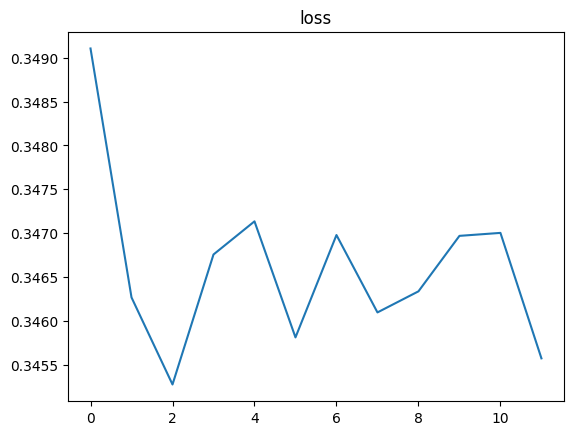

In [39]:
data_loader = load_data('./data/bbox_regression')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_model = get_model(device)

in_features = 256 * 6 * 6
out_features = 4
model = nn.Linear(in_features, out_features)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loss_list = train_model(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, device=device,
                        num_epochs=12)
plot_loss(loss_list)

### RCNN 테스트 코드

In [43]:
import time
import copy
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import alexnet
import torchvision.transforms as transforms

def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def get_transform():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform


def get_model(device=None):
    model = alexnet()
    num_classes = 2
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    model.load_state_dict(torch.load('./models/best_linear_svm_alexnet_car.pth'))
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    if device:
        model = model.to(device)

    return model


def draw_box_with_text(img, rect_list, score_list):
    for i in range(len(rect_list)):
        xmin, ymin, xmax, ymax = rect_list[i]
        score = score_list[i]

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=1)
        cv2.putText(img, "{:.3f}".format(score), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)


def nms(rect_list, score_list):
    nms_rects = list()
    nms_scores = list()

    rect_array = np.array(rect_list)
    score_array = np.array(score_list)

    idxs = np.argsort(score_array)[::-1]
    rect_array = rect_array[idxs]
    score_array = score_array[idxs]

    thresh = 0.3
    while len(score_array) > 0:
        nms_rects.append(rect_array[0])
        nms_scores.append(score_array[0])
        rect_array = rect_array[1:]
        score_array = score_array[1:]

        length = len(score_array)
        if length <= 0:
            break

        iou_scores = iou(np.array(nms_rects[len(nms_rects) - 1]), rect_array)
        # print(iou_scores)
        idxs = np.where(iou_scores < thresh)[0]
        rect_array = rect_array[idxs]
        score_array = score_array[idxs]

    return nms_rects, nms_scores

selectivesearch rects =  1799
[161  93 393 270] tensor([-0.1962,  1.0339], device='cuda:0') [0.22617753 0.7738225 ]
[168 135 337 288] tensor([-0.2509,  0.9523], device='cuda:0') [0.23090537 0.7690947 ]
[160 100 392 269] tensor([-0.1654,  1.0068], device='cuda:0') [0.23645152 0.7635485 ]
[160  75 390 288] tensor([0.2436, 0.8892], device='cuda:0') [0.34398678 0.65601325]
[157  84 349 281] tensor([-0.0553,  1.1930], device='cuda:0') [0.2229978  0.77700216]
[156 100 371 272] tensor([-0.2249,  1.2741], device='cuda:0') [0.1825664 0.8174336]
[157 100 347 203] tensor([0.2531, 1.0295], device='cuda:0') [0.31509492 0.6849051 ]
[155 152 392 272] tensor([-0.1238,  0.7775], device='cuda:0') [0.2887702 0.7112298]
[157  84 391 281] tensor([0.1618, 0.9279], device='cuda:0') [0.31733754 0.6826624 ]
[160  75 330 270] tensor([-0.2764,  1.0776], device='cuda:0') [0.20522857 0.7947715 ]
[161 100 322 255] tensor([-0.3710,  1.0389], device='cuda:0') [0.19625086 0.8037492 ]
[163  98 323 269] tensor([-0.3392,

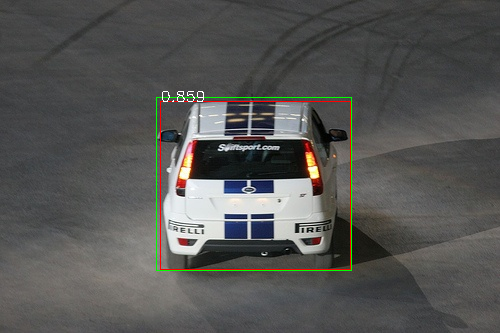

In [45]:
device = get_device()
transform = get_transform()
model = get_model(device=device)

gs = get_selective_search()

# test_img_path = './imgs/000007.jpg'
# test_xml_path = './imgs/000007.xml'
test_img_path = './imgs/000012.jpg'
test_xml_path = './imgs/000012.xml'

img = cv2.imread(test_img_path)
dst = copy.deepcopy(img)

bndboxs = parse_xml(test_xml_path)
for bndbox in bndboxs:
    xmin, ymin, xmax, ymax = bndbox
    cv2.rectangle(dst, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=1)

config(gs, img, strategy='f')
rects = get_rects(gs)
print("selectivesearch rects = ", len(rects))

# softmax = torch.softmax()

svm_thresh = 0.60

score_list = list()
positive_list = list()

# tmp_score_list = list()
# tmp_positive_list = list()
start = time.time()
for rect in rects:
    xmin, ymin, xmax, ymax = rect
    rect_img = img[ymin:ymax, xmin:xmax]

    rect_transform = transform(rect_img).to(device)
    output = model(rect_transform.unsqueeze(0))[0]

    if torch.argmax(output).item() == 1:
        probs = torch.softmax(output, dim=0).cpu().numpy()

        # tmp_score_list.append(probs[1])
        # tmp_positive_list.append(rect)

        if probs[1] >= svm_thresh:
            score_list.append(probs[1])
            positive_list.append(rect)
            # cv2.rectangle(dst, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=2)
            print(rect, output, probs)
end = time.time()
print('detect time: %d s' % (end - start))

# tmp_img2 = copy.deepcopy(dst)
# draw_box_with_text(tmp_img2, tmp_positive_list, tmp_score_list)
# cv2.imshow('tmp', tmp_img2)
#
# tmp_img = copy.deepcopy(dst)
# draw_box_with_text(tmp_img, positive_list, score_list)
# cv2.imshow('tmp2', tmp_img)

nms_rects, nms_scores = nms(positive_list, score_list)
print(nms_rects)
print(nms_scores)
draw_box_with_text(dst, nms_rects, nms_scores)

cv2_imshow(dst)